In [54]:

import numpy as np
import os
import csv
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.signal import savgol_filter
import math
import boris_extraction as boris
import pandas as pd
from scipy.stats import sem
from statistics import mean
from scipy.stats import wilcoxon


def get_spike_specs(path):
    
    """
    imports a spike_time and spike_unit from phy folder
    deletes spikes from units labeled noise in unit and timestamp array
    
    Args (1 total):
        path: path to phy folder
        path format: './folder/folder/phy'
    
    Returns (2):
        timestamps: numpy array of spike timestamps relative to sampling rate
        unit_array: numpy array of unit ids relative to timestamp array 
    """
    
    timestamps = 'spike_times.npy'
    unit = 'spike_clusters.npy'
    labels_dict = get_unit_labels(path)
    
    timestamps = np.load(os.path.join(path, timestamps))
    unit_array = np.load(os.path.join(path, unit))
   
    spikes_to_delete = []
   
    for spike in range(len(timestamps)): 
        if labels_dict[unit_array[spike].astype(str)] == 'noise':
                spikes_to_delete.append(spike)
        if spike != 0:
            if timestamps[spike - 1] == timestamps[spike]:
                print('2 spikes in a sampling')
                
    timestamps = np.delete(timestamps, spikes_to_delete)
    unit_array = np.delete(unit_array, spikes_to_delete)
    
    return timestamps, unit_array

def get_unit_labels(path):
    """
    creates a dictionary with unit id as key and label as value
    labels: good, mua, noise 
    
    Arg (1 total):
        path: path to phy folder
        
    Return (1):
        labels_dict: dict, unit ids (str): label (str)
    """
    
    labels = 'cluster_group.tsv'
    with open(os.path.join(path, labels), 'r') as f:
        reader = csv.DictReader(f, delimiter='\t')
        labels_dict = {row['cluster_id']: row['group'] for row in reader}
        
    return labels_dict

def get_unit_timestamps(timestamp_array, unit_array):
    """
    creates a dictionary of units to spikes
    values are spike timestamp arrays associated with the unit as key
    no noise units are included
    
    Arg(2 total):
        timestamp_array: numpy array, spike timestamps
        unit_array: numpy array, unit ids associated with spikes
    
    Return (1):
        timestamp_dict: dict, unit id (int) as keys, spike timestamps (numpy array) as values 
    """
    
    timestamp_dict = {}
    for spike in range(len(timestamp_array)): 
        if unit_array[spike] in timestamp_dict.keys():
            timestamp_list = timestamp_dict[unit_array[spike]] 
            timestamp_list = np.append(timestamp_list, timestamp_array[spike])
            timestamp_dict[unit_array[spike]] = timestamp_list
        else:
            timestamp_dict[unit_array[spike]] = timestamp_array[spike]
    
    return timestamp_dict

    
def get_spiketrain(timestamp_array, sampling_rate = 20000):
    """
    creates a spiketrain of ms time bins 
    each array element is the number of spikes recorded per ms
    
    Args (2 total):
        timestamp_array: numpy array, spike timestamp array
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Returns:
        spiketrain_ms_timebins: a numpy array 
            array elements are number of spikes per ms 
    """
    
    hz_to_ms = int(sampling_rate*.001)
    spiketrain = np.histogram(timestamp_array, bins=np.arange(0, timestamp_array[-1], hz_to_ms))[0]
    
    return spiketrain

def get_firing_rate(spiketrain, smoothing_window = 250, timebin = 1):
    """
    calculates firing rate (spikes/second)
    
    Args (3 total, 1 required):
        spiketrain: numpy array, in 1 ms time bin
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, window (ms) of firing rates returned

    Return (1):
        firing_rate: numpy array of firing rates in timebin sized windows
        
    """ 
    if timebin != 1:
        current_timebin = 0
        temp_spiketrain = np.zeros(math.ceil(len(spiketrain)/timebin))
        for i in range(0, len(spiketrain), timebin):
            try:
                temp_spiketrain[current_timebin] = sum(spiketrain[i:i+timebin])
                current_timebin += 1
            except IndexError:
                #should i pad here or just drop it? 
                temp_spiketrain[current_timebin] = sum(spiketrain[i:])
        spiketrain = temp_spiketrain
    weights = np.ones(smoothing_window) / smoothing_window / .001
    firing_rate = np.convolve(spiketrain, weights, mode='same')

    return firing_rate
    
def get_unit_spiketrains(labels_dict, spike_dict, sampling_rate = 20000):  
    """
    Creates a dictionary of spiketrains per good unit 
    where unit id is key and unit spike train is value
    does not create spiketrains for mua's
    
    Args (3 total, 3 required):
        labels_dict: dict, unit id for keys and labels for values
        spike_dict: dict, unit id for keys and spike timestamps for values
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Reutrn (1):
        unit_spiketrains: dict, unit ids as keys and unit spiketrains (in 1 ms timebins)
        
    """
    unit_spiketrains = {}
    
    for unit in spike_dict.keys():
        if labels_dict[str(unit)] == 'good':
            unit_spiketrains[unit] = get_spiketrain(spike_dict[unit], sampling_rate)
            
    return unit_spiketrains

def get_unit_firing_rates(labels_dict, spike_dict, smoothing_window = 250, timebin = 1, sampling_rate = 20000):  
    """
    Calculates firing rates per unit 
    
    Args (5 total, 2 required):
        labels_dict:dict, unit id for keys and labels for values
        spike_dict: dict, unit id for keys and spike timestamps for values
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1
        timebin: int, default = 1, window (ms) of firing rates returned
        sampling_rate: int, default=20000, sampling rate of ephys recording
        
    Return (1):
        unit_firing_rates: dict, unit ids as keys and unit firing rates as values
    """
    unit_firing_rates = {}
    for unit in spike_dict.keys():
        if labels_dict[str(unit)] == 'good':
            spiketrain = get_spiketrain(spike_dict[unit], sampling_rate)
            unit_firing_rates[unit] = get_firing_rate(spiketrain, smoothing_window, timebin)
        
    return unit_firing_rates

def get_event_spiketrains(events, timestamp_array, pre_window=0, post_window=0, sampling_rate=20000):
    """
    calculates spiketrains from timestamps for events
    optional pre-event and post-event windows (s) may be included

    Args (5 total, 2 required):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        timestamp_array: numpy array of spike timestamps in 1 ms windows 
        pre_window: int, default = 0, seconds prior to start of event returned
        post_window: int, default = 0, seconds after end of event returned
        sampling_rate: int, default=20000, sampling rate of ephys recording

    Returns (1):
        event_spiketrains: list of lists, each item in the 
        larger list is an event spiketrain, and each item in 
        the event spiketrain list is the number of spikes per 1 ms timebin
    """
    event_spiketrains = []
    spiketrain = get_spiketrain(timestamp_array, sampling_rate)
    pre_window_ms = pre_window*1000
    post_window_ms = post_window*1000
    longest_event = 0
    event_lengths = []
    for i in range(events.shape[0]):
        event_length = int(events[i][1] - events[i][0])
        event_lengths.append(event_length)
        if event_length > longest_event:
            longest_event = event_length
    for i in range(events.shape[0]):
        event_diff = int(longest_event - event_lengths[i])
        pre_event = int(events[i][0] - pre_window_ms)
        post_event = int(events[i][1] + post_window_ms + event_diff)
        event_spiketrain = spiketrain[pre_event:post_event]
        event_spiketrains.append(event_spiketrain)
    return event_spiketrains

def get_event_firing_rates(events, timestamp_array, smoothing_window = 250, timebin = 1,
                           sampling_rate = 20000, pre_window = 0, post_window = 0, equalize = False):
    """
    calculates firing rates for events
    
    Args (8 total, 2 required):
        events:numpy array of [[start (ms), stop (ms)] x n events]
        timestamp_array: numpy array of spike timestamps in 1 ms windows 
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1 
        timebin: int, default 1, timebin in ms for firing rate array
        sampling_rate: int, default=20000, sampling rate of ephys recording
        pre_window: int, default = 0, seconds prior to start of event returned
        post_window: int, default = 0, seconds after end of event returned
        equalize: Boolean, default False, if True, equalizes lengths of each event to longest event
        
    Return (1):
        event_firing_rates: lst of numpy arrays of firing rates 
    """
    event_firing_rates = []
    spiketrain = get_spiketrain(timestamp_array, sampling_rate)
    pre_window_ms = pre_window*1000
    post_window_ms = post_window*1000
    if equalize:
        longest_event = 0
        event_lengths = []
        for i in range(events.shape[0]):
            event_length = int(events[i][1] - events[i][0])
            event_lengths.append(event_length)
            if event_length > longest_event:
                longest_event = event_length
    for i in range(events.shape[0]):
        if equalize:
            event_diff = int(longest_event - event_lengths[i])
        else:
            event_diff = 0
        pre_event = int(events[i][0] - pre_window_ms)
        post_event = int(events[i][1] + post_window_ms + event_diff)
        event_spiketrain = spiketrain[pre_event:post_event]
        event_firing_rate = get_firing_rate(event_spiketrain)
        event_firing_rates.append(event_firing_rate)
    return event_firing_rates


    
def wilcoxon_average_firingrates(spike_dict, events, baseline_window, max_event=0, 
                                 smoothing_window = 250, timebin = 1, sampling_rate = 20000):
    """
    calculates the wilcoxon signed-rank test for average firing rates of two windows: event vs baseline
    baseline used is an amount of time immediately prior to the event
    wilcoxon signed-rank test is applied to two sets of measurements:
    average firing rate per event, average firing rate per baseline
    
    Args (7 total, 2 required):
        spike_dict: dict, keys are unit ids, and values is a numpy array of timestamps
        events:numpy array of [[start (ms), stop (ms)] x n events]
        baseline_window: int, length of baseline firing rate (s)
        max_event: int, default=0, max length of an event (s)
        smoothing_window: int, default = 250, smoothing average window (ms)
            min smoothing_window = 1 
        timebin: int, default 1, timebin in ms for firing rate array
        sampling_rate: int, default=20000, sampling rate of ephys recording

    Return (1):
        wilcoxon_df: pandas dataframe, columns are unit ids, row[0] is wilcoxon 
    
    """
    trimmed_events = np.zeros(events.shape)
    preevent_baseline = np.zeros(events.shape)
    for bout in range(len(events)):
        if max_event != 0:
            if events[bout][1] - events[bout][0] > (max_event*1000):
                trimmed_events[bout][1] = events[bout][0]+(max_event*1000)
                trimmed_events[bout][0] = events[bout][0]
            else:
                trimmed_events[bout] = events[bout]
        preevent_baseline[bout] = [(events[bout][0] - (baseline_window*1000)+1), (events[bout][0]-1)]
    unit_averages = {}
    for unit in unit_dict:
        event_firing_rates = get_event_firing_rates(trimmed_events, spike_dict[unit], smoothing_window, timebin, sampling_rate)
        preevent_firing_rates = get_event_firing_rates(preevent_baseline, spike_dict[unit], smoothing_window, timebin, sampling_rate)
        event_averages = []
        preevent_averages = []
        for event in range(len(event_firing_rates)):
            event_averages.append(mean(event_firing_rates[event]))
            preevent_averages.append(mean(preevent_firing_rates[event]))
        unit_averages[unit] = [event_averages, preevent_averages]
    wilcoxon_stats = {}
    for unit in unit_averages.keys(): 
        wilcoxon_stats[unit] = wilcoxon(unit_averages[unit][0], unit_averages[unit][1], method = 'approx')
    wilcoxon_df = pd.DataFrame.from_dict(wilcoxon_stats)
    return wilcoxon_df, trimmed_events, unit_averages


In [55]:
fam_path = '.\\proc\\20221219_114535_6_1_fam_merged.rec\\phy'
boris_df = pd.read_excel('C:\\Users\megha\\Documents\\Padilla-Coreano\\homecage_social_ephys_vids\\mp4vids\\annotated_behavior_cagfamnov.xlsx')
fam_df = boris_df[boris_df['Observation id'] == 'familiar_6_1_06282023']
cagemate_df = boris_df[boris_df['Observation id'] == 'cagemate_6_1_06282023']
novel_df = boris_df[boris_df['Observation id'] == 'novel_6_1_06282023']

In [56]:
fam_timestamps, fam_units = get_spike_specs(fam_path)
fam_spiketrain = get_spiketrain(fam_timestamps)
print(len(fam_spiketrain))
unit_labels = get_unit_labels(fam_path)
print(unit_labels)
unit_dict = get_unit_timestamps(fam_timestamps, fam_units)
sniffing_bouts = boris.get_behavior_bouts(fam_df, ['subject'], ['anogential sniffing', 'face sniffing'], 2, .3)
fam_event_firingrates = get_event_firing_rates(sniffing_bouts, fam_timestamps, 100)

1200554
{'1': 'good', '3': 'mua', '4': 'mua', '5': 'mua', '8': 'mua', '15': 'good', '16': 'noise', '19': 'good', '20': 'mua', '31': 'noise', '33': 'mua', '42': 'good', '44': 'mua', '55': 'good', '62': 'noise', '63': 'noise', '64': 'noise', '65': 'noise', '66': 'mua', '67': 'noise', '68': 'mua'}


In [57]:

fam_firing_rates = get_firing_rate(fam_spiketrain, 100, 1)
fam_firing_rates[0:100]

array([ 90.,  90.,  90.,  90.,  90.,  90.,  90.,  90.,  90.,  90.,  90.,
        90.,  90.,  90., 100., 110., 110., 110., 110., 110., 110., 110.,
       110., 120., 120., 120., 120., 120., 120., 120., 120., 120., 120.,
       120., 120., 120., 120., 120., 120., 120., 130., 130., 130., 130.,
       130., 130., 140., 140., 140., 140., 140., 140., 140., 150., 150.,
       160., 160., 160., 170., 170., 180., 180., 190., 190., 190., 190.,
       180., 180., 180., 180., 170., 170., 170., 170., 170., 170., 170.,
       170., 170., 170., 170., 170., 160., 160., 170., 170., 170., 170.,
       160., 150., 150., 160., 170., 170., 170., 170., 170., 170., 170.,
       170.])

In [59]:
fam_event_firingrates[1][0:10]

array([ 96.,  96.,  96.,  96.,  96.,  96.,  96., 100., 100., 104.])

In [60]:
wilcoxon_df, trimmed_sniffing_bouts, unit_averages = wilcoxon_average_firingrates(unit_dict, sniffing_bouts, 2, 5, 100)
wilcoxon_df

trimmed_sniffing_bouts

array([[ 606700.,  610767.],
       [ 611133.,  613166.],
       [ 614133.,  618566.],
       [ 618567.,  623432.],
       [ 640300.,  642367.],
       [ 661267.,  666267.],
       [ 698367.,  701100.],
       [ 774900.,  777133.],
       [ 810500.,  813467.],
       [ 836433.,  841433.],
       [ 847900.,  852200.],
       [1049933., 1052067.],
       [1092033., 1096067.],
       [1100800., 1103767.],
       [1110433., 1113467.]])

In [48]:
unit_sniffing_rates_prewindow = {}
for unit in unit_dict:
    sniffing_firing_rates = get_event_firing_rates(trimmed_sniffing_bouts, unit_dict[unit], 100, 1, 20000, 2, 0, True)
    unit_sniffing_rates_prewindow[unit] = sniffing_firing_rates

In [53]:
unit_sniffing_rates_prewindow[8][1][200:250]

array([12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.,
       12., 12., 12., 12., 12., 12., 12., 12., 12., 12., 12.])

In [50]:
len(unit_sniffing_rates_prewindow[8][0])

6751

In [51]:
unit_averages

{8: [[4.781561026715558,
   2.3856502242152464,
   4.520076481835564,
   5.05892547660312,
   3.4433443344334433,
   3.1572300568301412,
   3.6231884057971016,
   2.0161290322580645,
   2.207505518763797,
   1.7587876236581772,
   2.1091088620093803,
   1.5915119363395225,
   1.5852047556142668,
   1.6011773362766741,
   2.043806104129264],
  [1.2921669525443111,
   4.251572327044025,
   3.1012006861063464,
   5.6786735277301315,
   3.9016580903373357,
   5.422527158376215,
   4.002287021154945,
   0.5717552887364208,
   3.2978845054316754,
   2.440251572327044,
   0.5717552887364208,
   4.574042309891366,
   6.289308176100629,
   3.4305317324185247,
   7.956546598056032]],
 19: [[14.495547407019382,
   24.932735426008968,
   18.706500956022946,
   23.652512998266896,
   25.298129812981298,
   20.23068827615239,
   20.853462157809982,
   21.405241935483872,
   22.975717439293597,
   24.151547042727845,
   22.995803505307332,
   14.5315649867374,
   15.709379128137384,
   11.68064753495

[array([ 4.,  4.,  4., ..., 16., 16., 16.]), array([20., 20., 20., ..., 16., 16., 16.]), array([24., 24., 24., ..., 16., 16., 16.]), array([20., 20., 20., ..., 16., 16., 16.]), array([28., 28., 28., ..., 20., 20., 20.]), array([12., 12., 12., ..., 20., 20., 24.]), array([24., 28., 28., ...,  4.,  4.,  4.]), array([20., 20., 20., ..., 20., 20., 20.]), array([8., 8., 8., ..., 4., 4., 4.]), array([32., 32., 32., ..., 20., 20., 20.]), array([ 8., 12., 12., ..., 12., 12., 12.]), array([ 8.,  8.,  8., ..., 16., 16., 16.]), array([ 8.,  8.,  8., ..., 24., 24., 24.]), array([12., 12., 12., ...,  8.,  8.,  8.]), array([20., 20., 20., ...,  8.,  8.,  8.])]
(6751,)
(6751,)


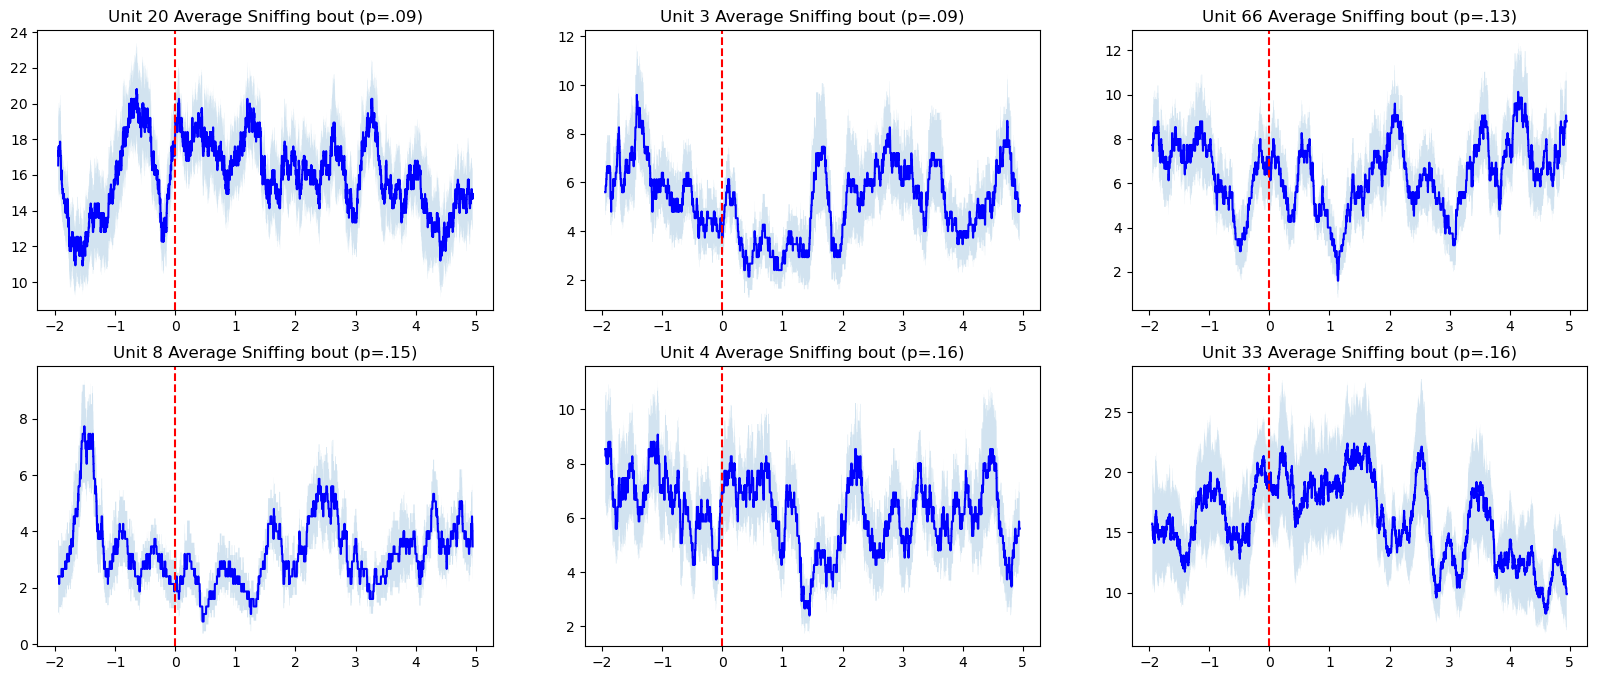

In [52]:
mean_arr = np.mean(unit_sniffing_rates_prewindow[20], axis=0)
print(unit_sniffing_rates_prewindow[20])
print(mean_arr.shape)
sem_arr = sem(unit_sniffing_rates_prewindow[20], axis=0)
pos_sem = mean_arr+sem_arr
neg_sem = mean_arr-sem_arr
x = np.linspace(start=-1.95,stop=4.95,num=mean_arr.shape[0])
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.plot(x, mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(x, neg_sem, pos_sem, alpha=0.2)
plt.title('Unit 20 Average Sniffing bout (p=.09)')

three_mean_arr = np.mean(unit_sniffing_rates_prewindow[3], axis = 0)
three_sem_arr = sem(unit_sniffing_rates_prewindow[3], axis=0)
three_pos_sem = three_mean_arr+three_sem_arr
three_neg_sem = three_mean_arr-three_sem_arr
three_x = np.linspace(start=-1.95,stop=4.95,num=three_mean_arr.shape[0])
print(three_mean_arr.shape)
plt.subplot(2,3,2)
plt.plot(three_x, three_mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(three_x, three_neg_sem, three_pos_sem, alpha=0.2)
plt.title('Unit 3 Average Sniffing bout (p=.09)')


sixtysix_mean_arr = np.mean(unit_sniffing_rates_prewindow[66], axis = 0)
sixtysix_sem_arr = sem(unit_sniffing_rates_prewindow[66], axis=0)
sixtysix_pos_sem = sixtysix_mean_arr+sixtysix_sem_arr
sixtysix_neg_sem = sixtysix_mean_arr-sixtysix_sem_arr
sixtysix_x = np.linspace(start=-1.95,stop=4.95,num=sixtysix_mean_arr.shape[0])
plt.subplot(2,3,3)
plt.plot(sixtysix_x, sixtysix_mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(sixtysix_x, sixtysix_neg_sem, sixtysix_pos_sem, alpha=0.2)
plt.title('Unit 66 Average Sniffing bout (p=.13)')

eight_mean_arr = np.mean(unit_sniffing_rates_prewindow[8], axis = 0)
eight_sem_arr = sem(unit_sniffing_rates_prewindow[8], axis=0)
eight_pos_sem = eight_mean_arr+eight_sem_arr
eight_neg_sem = eight_mean_arr-eight_sem_arr
eight_x = np.linspace(start=-1.95,stop=4.95,num=eight_mean_arr.shape[0])
plt.subplot(2,3,4)
plt.plot(eight_x, eight_mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(eight_x, eight_neg_sem, eight_pos_sem, alpha=0.2)
plt.title('Unit 8 Average Sniffing bout (p=.15)')



four_mean_arr = np.mean(unit_sniffing_rates_prewindow[4], axis = 0)
four_sem_arr = sem(unit_sniffing_rates_prewindow[4], axis=0)
four_pos_sem = four_mean_arr+four_sem_arr
four_neg_sem = four_mean_arr-four_sem_arr
four_x = np.linspace(start=-1.95,stop=4.95,num=four_mean_arr.shape[0])
plt.subplot(2,3,5)
plt.plot(four_x, four_mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(four_x, four_neg_sem, four_pos_sem, alpha=0.2)
plt.title('Unit 4 Average Sniffing bout (p=.16)')

thirtythree_mean_arr = np.mean(unit_sniffing_rates_prewindow[33], axis = 0)
thirtythree_sem_arr = sem(unit_sniffing_rates_prewindow[33], axis=0)
thirtythree_pos_sem = thirtythree_mean_arr+thirtythree_sem_arr
thirtythree_neg_sem = thirtythree_mean_arr-thirtythree_sem_arr
thirtythree_x = np.linspace(start=-1.95,stop=4.95,num=thirtythree_mean_arr.shape[0])
plt.subplot(2,3,6)
plt.plot(thirtythree_x, thirtythree_mean_arr, c= 'b')
plt.axvline(x=0, color='r', linestyle='--')
plt.fill_between(thirtythree_x, thirtythree_neg_sem, thirtythree_pos_sem, alpha=0.2)
plt.title('Unit 33 Average Sniffing bout (p=.16)')

plt.show()